#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Инструкция по выполнению проекта
* Загрузите данные и выполните их ресемплирование по одному часу.
* Проанализируйте данные.
* Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
* Проверьте данные на тестовой выборке и сделайте выводы.

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл в датафрейм, назначив даты индексом

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим первые строки фрейма и общую информацию

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, есть ли пропуски

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Проверим индекс на монотонность

In [6]:
df.index.is_monotonic

True

Ресемплируем данные по часу

In [7]:
df = df.resample('1H').sum()

## Анализ

Определим функцию для построения графиков

In [8]:
sns.set(rc={'figure.figsize':(15,4)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики

In [9]:
decomposed = seasonal_decompose(df)

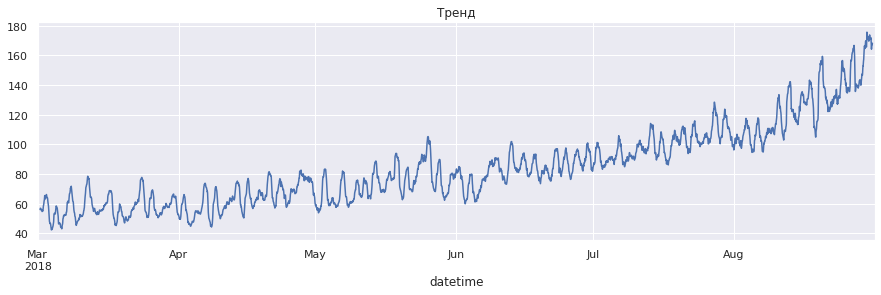

In [10]:
lineplot(decomposed.trend, 'Тренд')

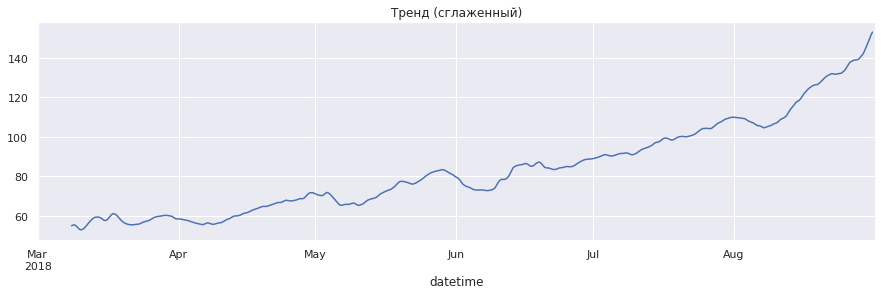

In [11]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

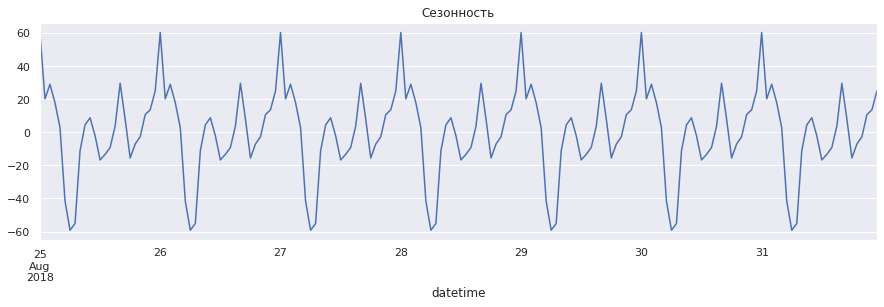

In [12]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

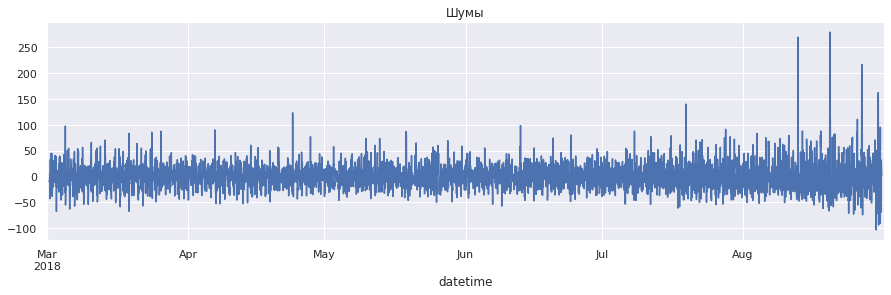

In [13]:
lineplot(decomposed.resid, 'Шумы')

Выводы:
* Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями
* Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру

## Обучение

### Подготовка признаков

Создадим признаки для горизонта прогнозирования в один шаг

In [14]:
def get_features(df_learning):
    df_learning['month'] = df_learning.index.month
    df_learning['day'] = df_learning.index.day
    df_learning['dayofweek'] = df_learning.index.dayofweek
    df_learning['hour'] = df_learning.index.hour
    
    for lag in range(1, 6):
        df_learning['lag_{}'.format(lag)] = df_learning['num_orders'].shift(lag)
    
    df_learning['rolling_mean'] = df_learning['num_orders'].shift().rolling(1).mean()
    df_learning.dropna(inplace=True)
    
    return df_learning

In [15]:
df_learning = df.copy()
df_learning = get_features(df_learning)

In [16]:
df.shape

(4416, 1)

In [17]:
df_learning.shape

(4411, 11)

Разделим данные на обучающую и тестовую выборки

In [18]:
features = df_learning.drop(['num_orders'], axis=1) # выделение признаков
target = df_learning['num_orders']

In [19]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=17)

### Обучение моделей

Обучим различные модели и добавим модели и рассчитанный RMSE в массив

In [20]:
train_models = []

#### Линейная регрессия

In [21]:
model = LinearRegression()

In [22]:
model.fit(features_train, target_train)
predictions = model.predict(features_train)

In [23]:
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

30.49423537423937

In [24]:
train_models.append([model, rmse])

#### DecisionTreeRegressor

In [25]:
model = DecisionTreeRegressor(random_state=12345)

In [26]:
parameters = {'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)

In [27]:
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)

In [28]:
gsearch.fit(features_train, target_train)
gsearch.best_params_

{'max_depth': 7}

In [29]:
predictions = gsearch.predict(features_train)
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

22.023192400699568

In [30]:
train_models.append([gsearch, rmse])

#### RandomForestRegressor

In [31]:
model = RandomForestRegressor(random_state=12345)

In [32]:
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)

In [33]:
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)

In [34]:
gsearch.fit(features_train, target_train)
gsearch.best_params_

{'max_depth': 9, 'n_estimators': 90}

In [35]:
predictions = gsearch.predict(features_train)
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

16.987253846307453

In [36]:
train_models.append([gsearch, rmse])

#### CatBoost

In [37]:
model = CatBoostRegressor(verbose=False)

In [38]:
model.fit(features_train, target_train, verbose=False)
predictions = model.predict(features_train)

In [39]:
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

13.316762140896047

In [40]:
train_models.append([model, rmse])

#### LightGBM

In [41]:
model = lgb.LGBMRegressor()

In [42]:
model.fit(features_train, target_train, verbose=False)
predictions = model.predict(features_train)

In [43]:
rmse = mean_squared_error(target_train, predictions, squared=False)
rmse

14.964692845001576

In [44]:
train_models.append([model, rmse])

#### Результаты

Преобразуем массив в датафрейм результатов для удобства отображения и отсортируем по возрастанию RMSE

In [45]:
result = pd.DataFrame(train_models, columns=['model', 'rmse_train'])

In [46]:
pd.options.display.max_colwidth = 0

In [47]:
display(result.sort_values(by='rmse_train'))

,model,rmse_train
3,<catboost.core.CatBoostRegressor object at 0x7f307bd414c0>,13.316762
4,LGBMRegressor(),14.964693
2,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),\n estimator=RandomForestRegressor(random_state=12345),\n param_grid={'max_depth': range(1, 11, 2),\n 'n_estimators': range(50, 100, 10)})",16.987254
1,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),\n estimator=DecisionTreeRegressor(random_state=12345),\n param_grid={'max_depth': range(1, 11, 2)})",22.023192
0,LinearRegression(),30.494235


## Тестирование

Протестируем обученные модели на тестовых данных и добавим их RMSE в датафрейм с результатами, а также построим графики исходного и предсказанных рядов для каждой модели

In [48]:
test_models = []

In [49]:
def display_result(target, pred, rmse):
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)
    
    lineplot(result, 'RMSE='+str(rmse))

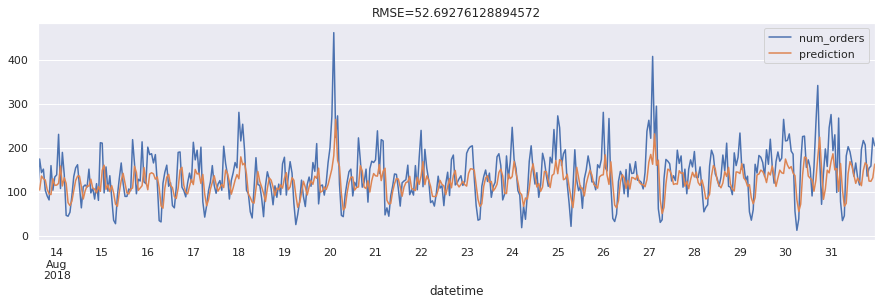

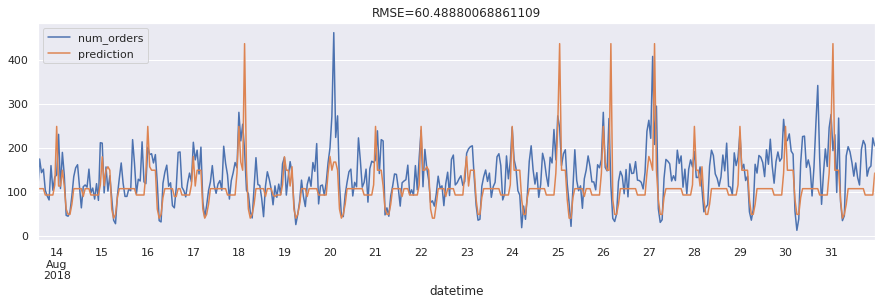

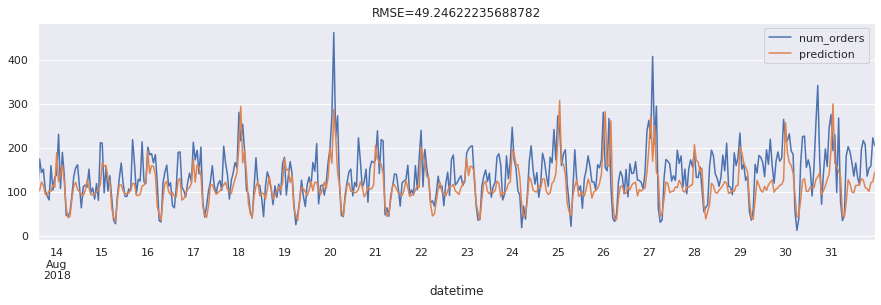

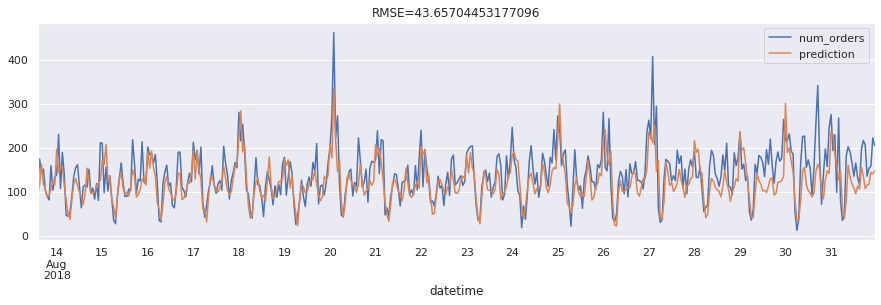

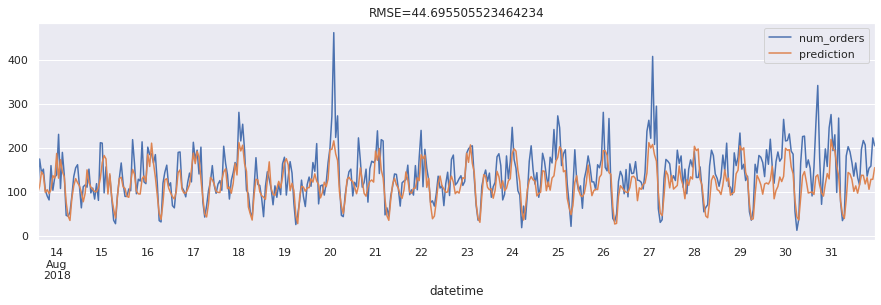

In [50]:
for i in range(len(train_models)):
    predictions = train_models[i][0].predict(features_test)
    rmse = mean_squared_error(target_test, predictions, squared=False)
    display_result(target_test, predictions, rmse)
    test_models.append(rmse)

In [51]:
result['rmse_test'] = pd.Series(test_models)

In [52]:
result.sort_values(by='rmse_test')

,model,rmse_train,rmse_test
3,<catboost.core.CatBoostRegressor object at 0x7f307bd414c0>,13.316762,43.657045
4,LGBMRegressor(),14.964693,44.695506
2,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),\n estimator=RandomForestRegressor(random_state=12345),\n param_grid={'max_depth': range(1, 11, 2),\n 'n_estimators': range(50, 100, 10)})",16.987254,49.246222
0,LinearRegression(),30.494235,52.692761
1,"GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),\n estimator=DecisionTreeRegressor(random_state=12345),\n param_grid={'max_depth': range(1, 11, 2)})",22.023192,60.488801


Только CatBoost и LightGBM демонстрируют RMSE ниже 48, у остальных результаты хуже